In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models, regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import load_model

In [24]:
train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

In [25]:
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [26]:
X_train, X_valid = train_test_split(train_df,  train_size=0.8 , shuffle= True, random_state= 123)

In [27]:
X_train.head()

,filepaths,labels
2730,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
4748,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
4811,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
3789,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
1672,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor


In [181]:
train_data_dir= "/kaggle/input/brain-tumor-mri-dataset/Training"
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

IMAGE_SIZE =(256,256)
BATCH_SIZE = 32

# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)


X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle = False,
    seed=42,  # Ensure reproducibility
    image_size=IMAGE_SIZE,  # Resize images to 128x128
    batch_size=BATCH_SIZE  # Batch size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [182]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to transform images into float32
X_train_normalized = X_train.map(normalize_img)
X_val_normalized = X_val.map(normalize_img)

#Apply MRI-specific normalization:
#def mri_normalize(image, label):
#    """Applies MRI-specific normalization."""
#    # Z-score normalization
#    mean = tf.reduce_mean(image)
#    std = tf.math.reduce_std(image)
#    normalized_image = (image - mean) / std
#    return normalized_image, label

#X_train_normalized = X_train_normalized.map(mri_normalize)
#X_val_normalized = X_val_normalized.map(mri_normalize)

Original Data:


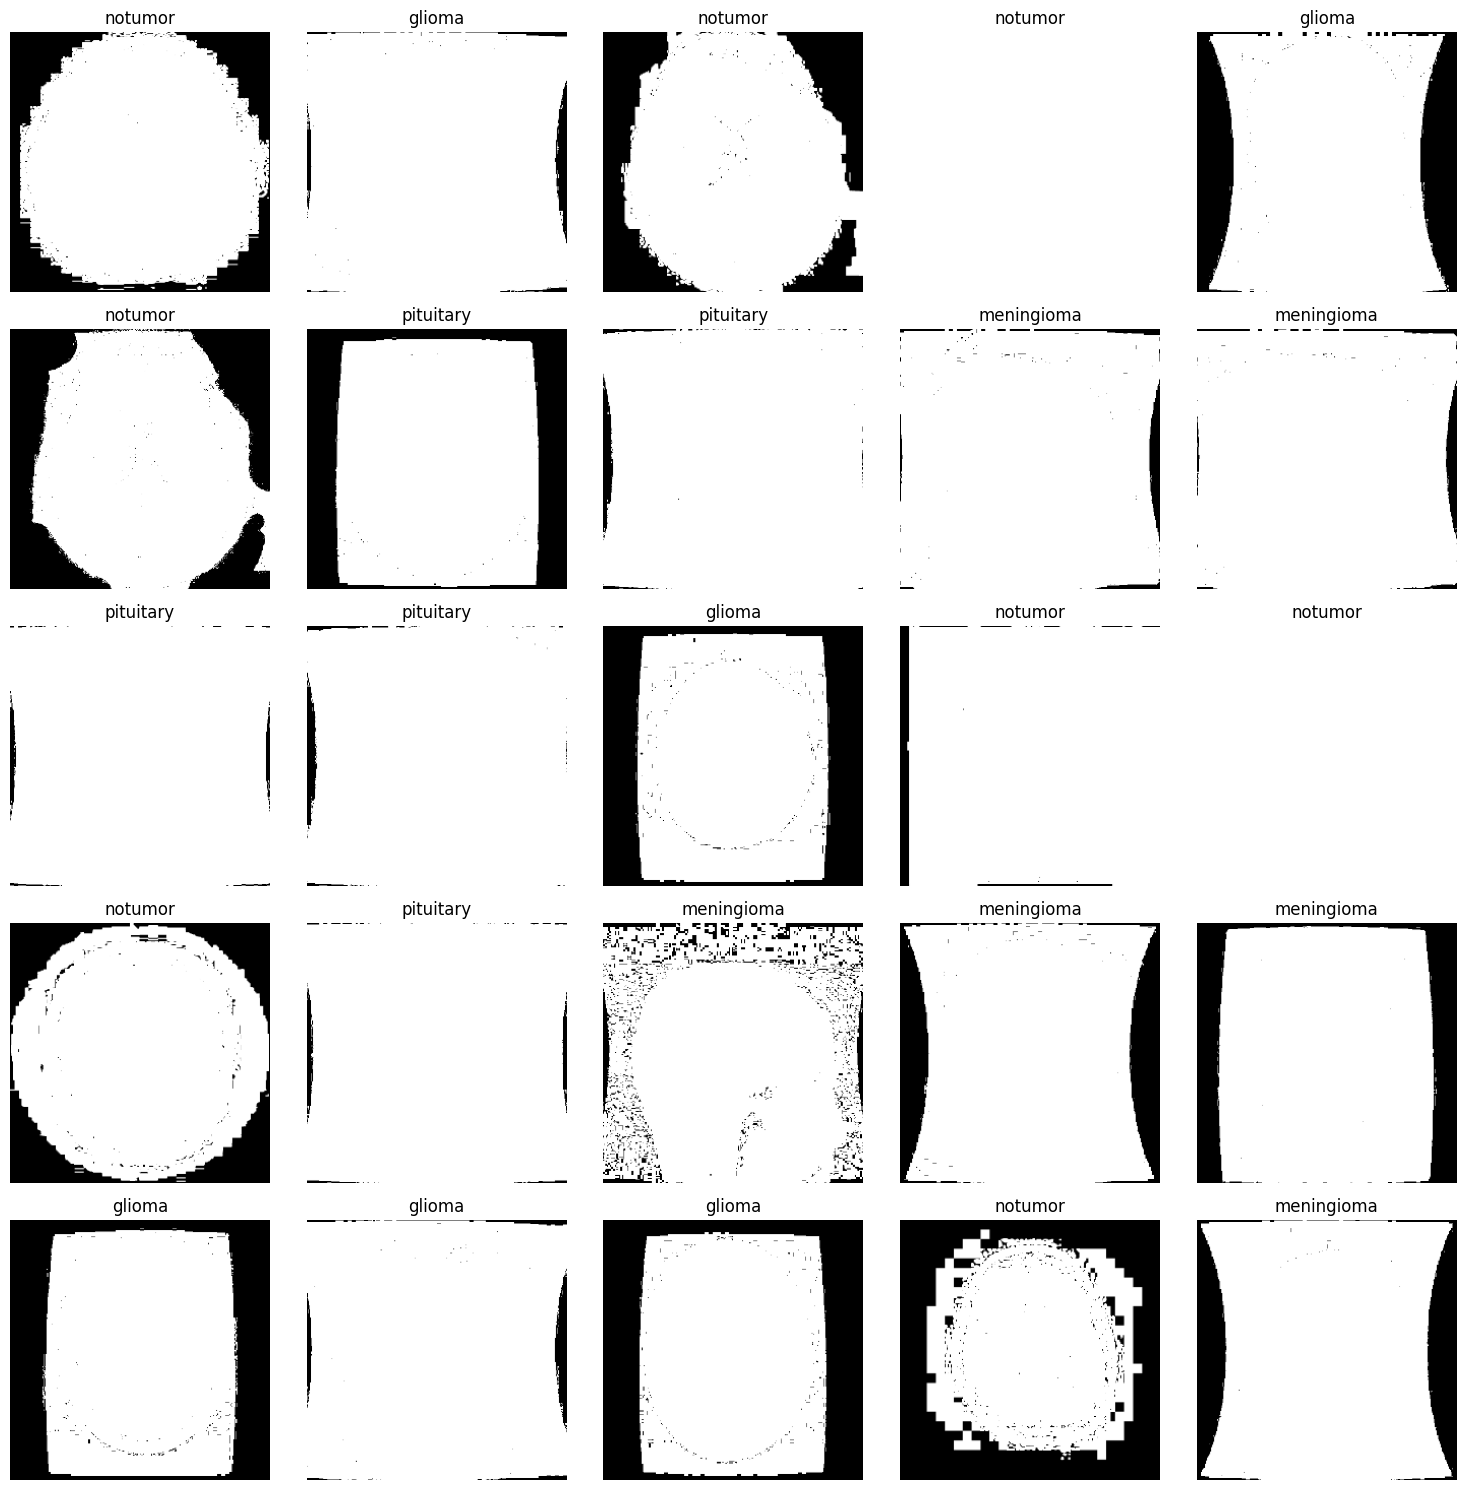

Normalized Data:


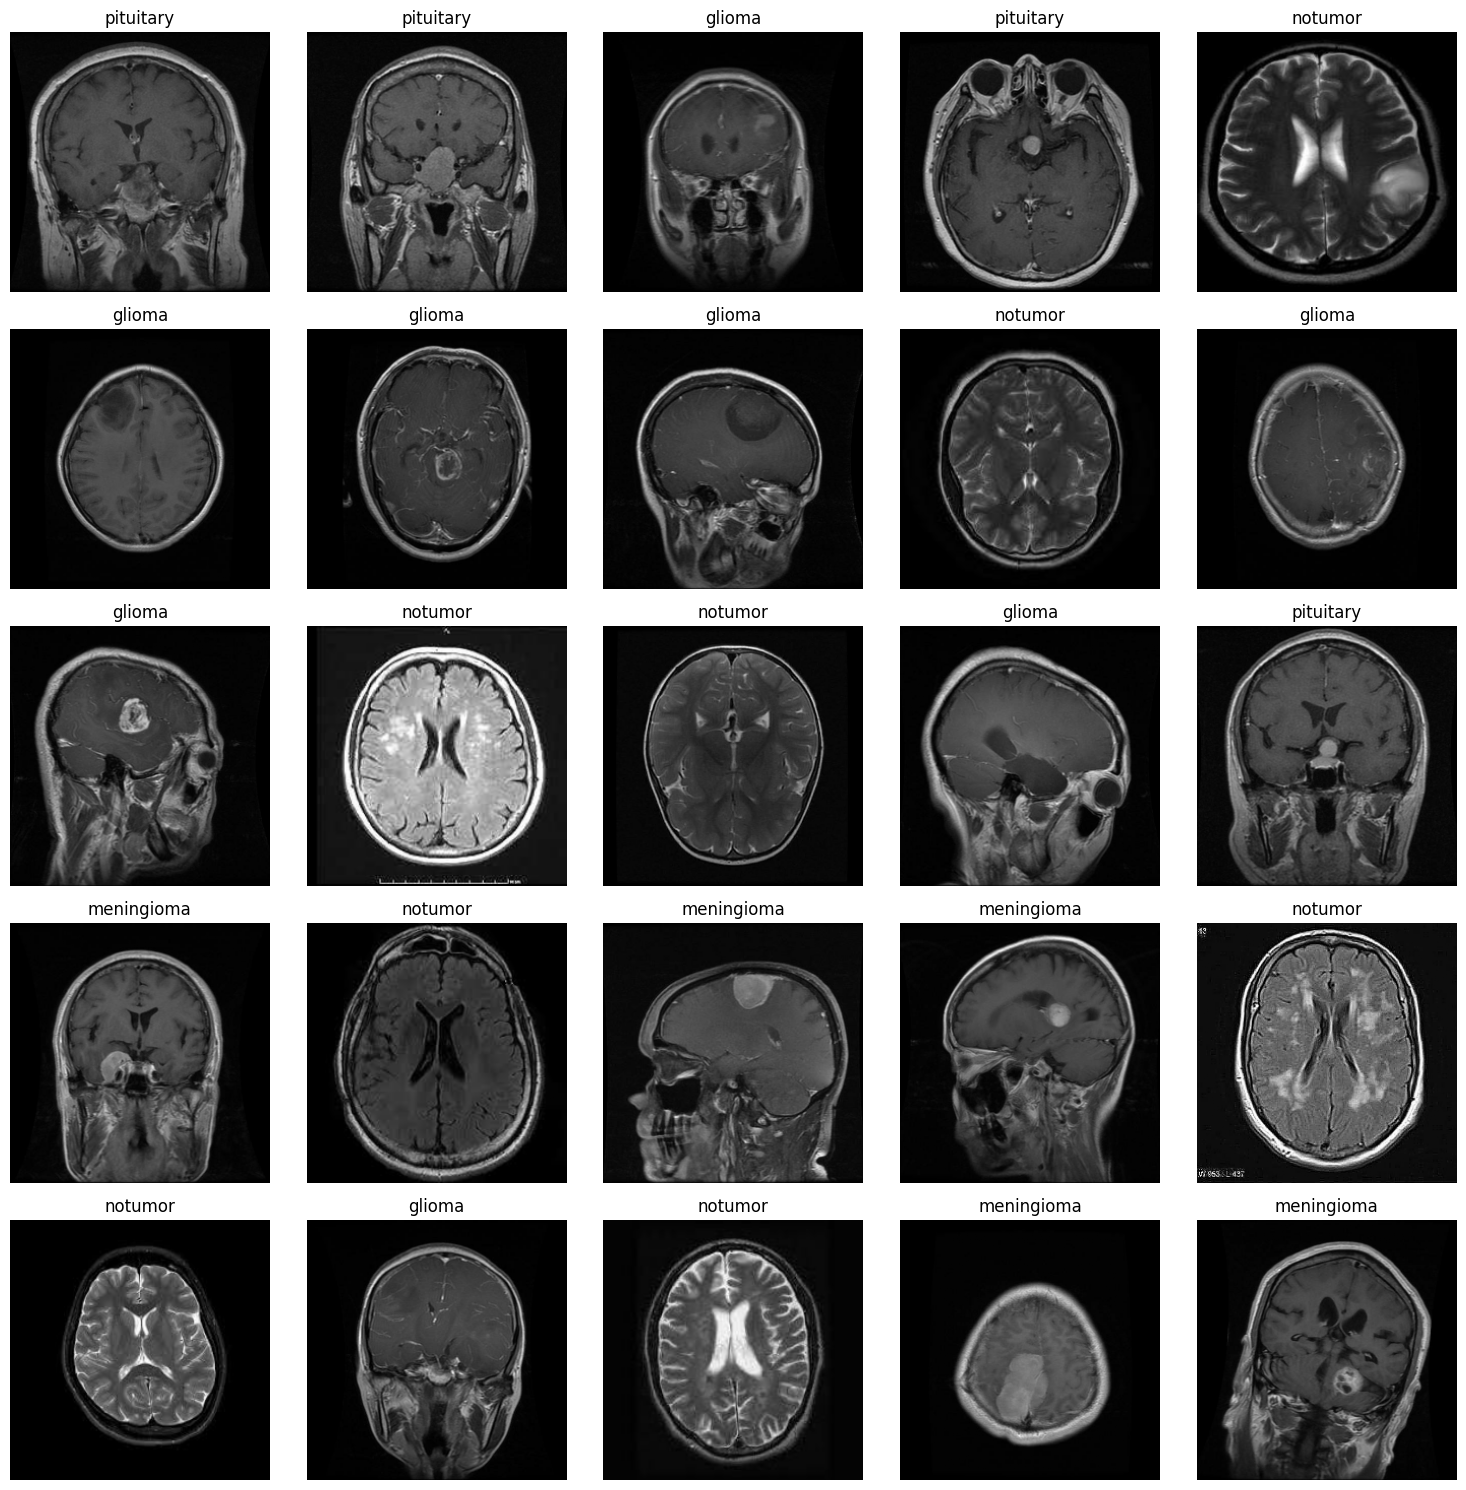

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_images_with_labels(dataset, class_names, num_images=25, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("float32"), cmap='gray')
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get class names from the dataset
class_names = X_train.class_names

# Plot original data with labels
print("Original Data:")
plot_images_with_labels(X_train, class_names)

# Plot normalized data with labels
print("Normalized Data:")
plot_images_with_labels(X_train_normalized, class_names)

In [ ]:
import tensorflow as tf

# Define the number of classes
num_classes = len(class_names)  # Replace with the actual number of classes

def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=num_classes)

X_train_encoded = X_train_normalized.map(one_hot_encode)
X_val_encoded = X_val_normalized.map(one_hot_encode)

# Shuffle and batch the datasets
#X_train_encoded = X_train_encoded.shuffle(buffer_size=500).batch(BATCH_SIZE)
#X_val_encoded = X_val_encoded.batch(BATCH_SIZE)

# Debug the dataset shapes
for image_batch, label_batch in X_train_encoded.take(1):
    print("Image batch shape:", image_batch.shape)  # Should be (batch_size, 256, 256, 3)
    print("Label batch shape:", label_batch.shape)  # Should be (batch_size, num_classes)


# Define the model

# Define the regularizer (choose one)
l1_regularizer = regularizers.L1(1e-5)      # L1 Regularization
l2_regularizer = regularizers.L2(1e-4)      # L2 Regularization
l1_l2_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4)  # L1 + L2 Regularization

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),

    # Convolutional layers with regularization
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu',
                           kernel_regularizer=l1_l2_regularizer),
    tf.keras.layers.BatchNormalization(),

    # Fully connected layers with regularization
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax',
                          kernel_regularizer=l1_l2_regularizer)
])

# Compile and train the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

#history = model.fit(
#    X_train_encoded,
#    validation_data=X_val_encoded,
#    epochs=40,
#    batch_size=32
#)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)


In [165]:
# Print model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131,524 (8.13 MB)

 Trainable params: 2,129,604 (8.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [186]:
# Set up directories for saving the model and TensorBoard logs
checkpoint_dir = './checkpoints'
tensorboard_log_dir = './logs'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [187]:
callbacks = [
    # Save the model with the minimum valdiation loss
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),

    # Early stopping to stop training when validation loss stops decreasing
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Reduce learning rate when the validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),

    # TensorBoard logging
    TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1, write_images=True)
]

In [188]:
# Training the model with callbacks and storing the training history
history = model.fit(
    X_train_encoded,  # Training data generator or dataset
    epochs=60,
    batch_size=32,
    validation_data=X_val_encoded,  # Validation data generator or dataset
    callbacks=callbacks
)

Epoch 1/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5735 - auc_6: 0.8261 - loss: 1.3662 - precision_6: 0.7176 - recall_6: 0.3526
Epoch 1: val_loss improved from inf to 2.53763, saving model to ./checkpoints/best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.5742 - auc_6: 0.8265 - loss: 1.3652 - precision_6: 0.7181 - recall_6: 0.3536 - val_accuracy: 0.2636 - val_auc_6: 0.5297 - val_loss: 2.5376 - val_precision_6: 0.2636 - val_recall_6: 0.2636 - learning_rate: 1.0000e-05
Epoch 2/60
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7466 - auc_6: 0.9250 - loss: 1.0626 - precision_6: 0.8366 - recall_6: 0.6336
Epoch 2: val_loss did not improve from 2.53763
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.7467 - auc_6: 0.9250 - loss: 1.0623 - precision_6: 0.8366 - recall_6: 0.6338 - val_accuracy: 0.2636 - val_auc_6: 0.5340 - val_loss: 5.5102 - val_precision_6: 0.2636 - val_recall_6: 0.2636 - learning_rate: 1.0000e-05
Epoch 3/60
143/143 ━━

In [189]:
print(history.history.keys())

dict_keys(['accuracy', 'auc_6', 'loss', 'precision_6', 'recall_6', 'val_accuracy', 'val_auc_6', 'val_loss', 'val_precision_6', 'val_recall_6', 'learning_rate'])


In [190]:
# Find the index of the best validation accuracy
best_epoch_index = np.argmax(history.history['val_accuracy'])

print(f"Best epoch (index) based on validation accuracy: {best_epoch_index}")

Best epoch (index) based on validation accuracy: 28


In [196]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")
print(f"Training Precision: {history.history['precision_6'][best_epoch_index]}")
print(f"Validation Precision: {history.history['val_precision_1'][best_epoch_index]}")
print(f"Training Recall: {history.history['recall_6'][best_epoch_index]}")
print(f"Validation Recall: {history.history['val_recall_6'][best_epoch_index]}")
print(f"Training AUC: {history.history['auc_6'][best_epoch_index]}")
print(f"Validation AUC: {history.history['val_auc_6'][best_epoch_index]}")


Specific Metrics (Training & Validation):
Training Accuracy: 0.9577680230140686
Validation Accuracy: 0.9369527101516724
Training Loss: 0.5026618838310242
Validation Loss: 0.5704478025436401
Training Precision: 0.9634389281272888


KeyError: 'val_precision_1'

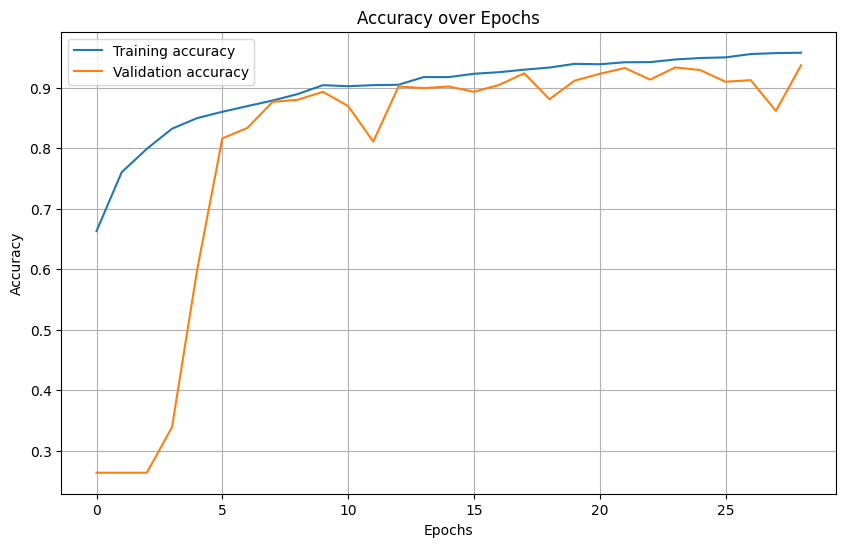

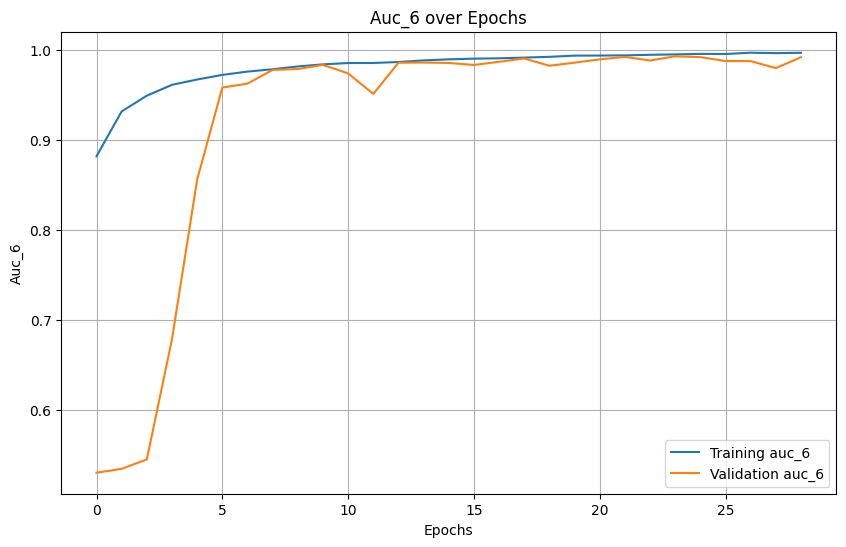

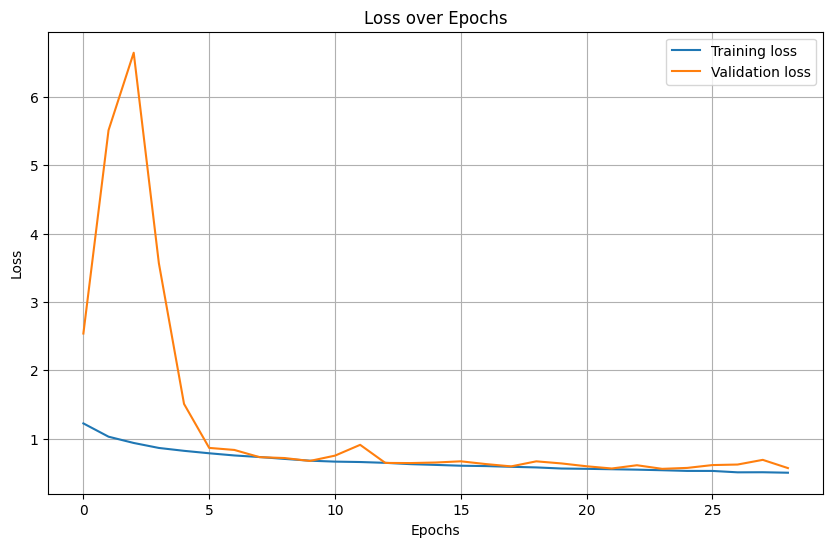

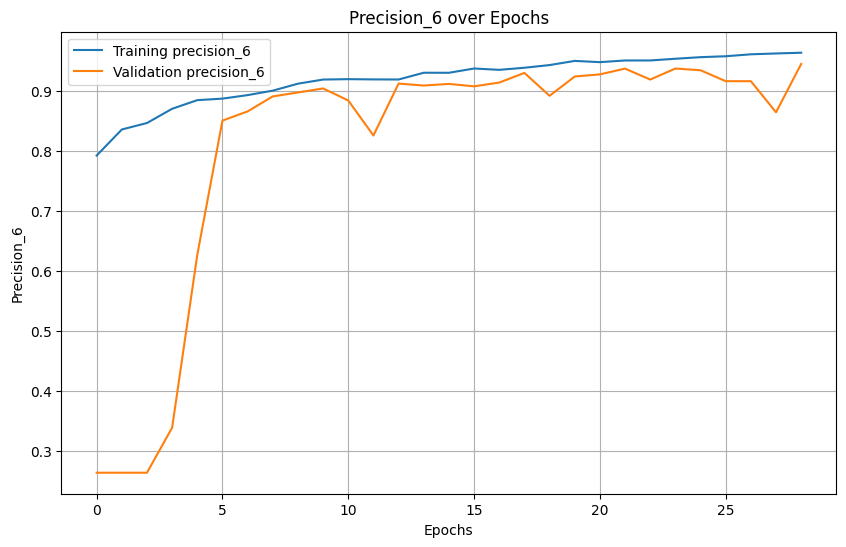

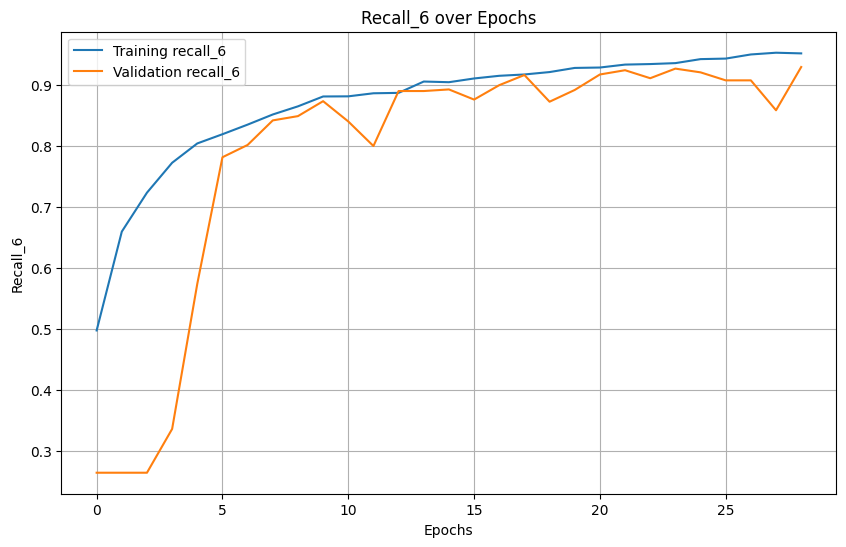

In [197]:
# Define the metrics to plot
metrics = ['accuracy', 'auc_6', 'loss', 'precision_6', 'recall_6']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [198]:
# Evaluate on test data
X_test_normalized = X_test.map(normalize_img)
X_test_encoded = X_test_normalized.map(one_hot_encode)
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test_encoded, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8674 - auc_6: 0.9742 - loss: 0.7295 - precision_6: 0.8758 - recall_6: 0.8607
Test Accuracy: 0.9176


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


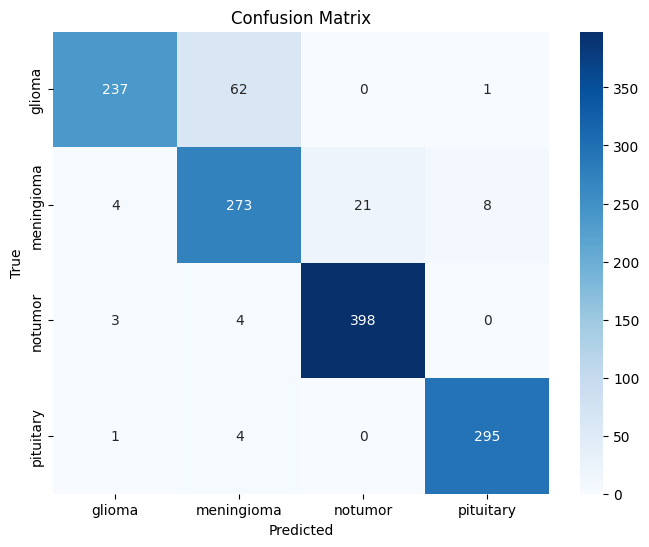

In [194]:
# Retrieve class names
class_names = X_test.class_names  # This contains the list of class names in order

# Get the predicted probabilities for the test set
y_pred_proba = model.predict(X_test_encoded, verbose=1)

# Convert predicted probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Calculate metrics like the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


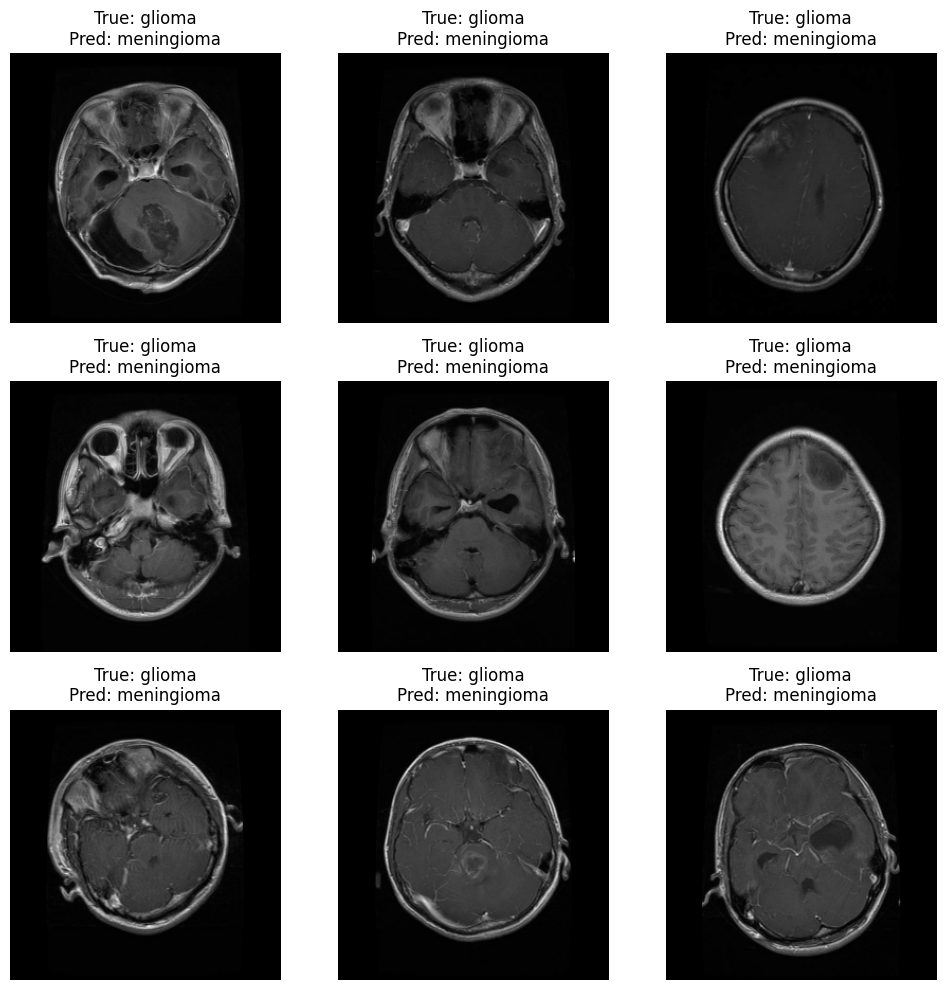

In [195]:
# Fetch a batch of images and labels
batch = next(iter(X_test))
test_images, test_labels = batch

# Predict on the batch
batch_predictions = model.predict(test_images)
batch_predicted_classes = np.argmax(batch_predictions, axis=1)

# Visualize the predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))  # Convert tensor to uint8 array
    true_label = class_names[np.argmax(test_labels[i].numpy())]
    predicted_label = class_names[batch_predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()